# Lotka-Volterra LFM

This example looks at predator-prey dynamics using a dataset generated by the Lotka-Volterra equations.

The prey is assumed to be a latent force upon which we assign a GP prior with a periodic kernel.

In [2]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.nn import Parameter
from torch.optim import Adam
from gpytorch.optim import NGD
from gpytorch.constraints import Positive, Interval

from alfi.models import OrdinaryLFM, MultiOutputGP #MLPLFM
from alfi.utilities.torch import inv_softplus, softplus
from alfi.datasets import DeterministicLotkaVolterra
from alfi.plot import Plotter1d, plot_phase, Colours
from alfi.configuration import VariationalConfiguration
from alfi.trainers import VariationalTrainer

import numpy as np

f64 = np.float64

Lotka-Voltera is in greek mode.
Creating dataset...
Num training points:  13


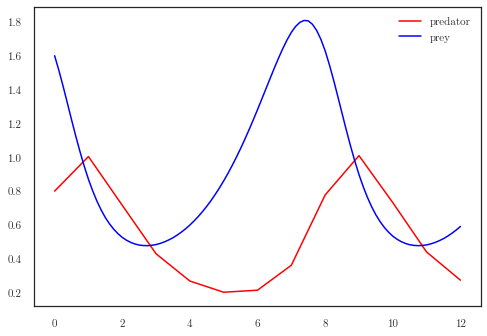

In [28]:
dataset = DeterministicLotkaVolterra(
    alpha = 2./3,
    beta = 4./3,
    gamma = 1.,
    delta = 1.,
    steps=13,
    end_time=12,
    fixed_initial=0.8,
)
x_min, x_max = min(dataset.times), max(dataset.times)

plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='predator')
plt.plot(torch.linspace(x_min, x_max, dataset.prey.shape[0]), dataset.prey, c='blue', label='prey')
plt.legend()
num_latents = 1
num_outputs = 1
num_training = dataset[0][0].shape[0]
num_inducing = 20

print('Num training points: ', num_training)
output_names = np.array(['pred','prey'])

In [29]:
class LotkaVolterra(OrdinaryLFM):
    """Outputs are predator. Latents are prey"""
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.decay_constraint = Interval(0., 1.5)
        self.raw_decay = Parameter(self.decay_constraint.inverse_transform(torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_growth = Parameter(self.positivity.inverse_transform(0.5*torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_initial = Parameter(self.positivity.inverse_transform(0.3+torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.true_f = dataset.prey[::3].unsqueeze(0).repeat(self.config.num_samples, 1).unsqueeze(1)
        print(self.true_f.shape)
    @property
    def decay_rate(self):
        return self.decay_constraint.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.decay_constraint.inverse_transform(value)

    @property
    def growth_rate(self):
        return softplus(self.raw_growth)

    @growth_rate.setter
    def growth_rate(self, value):
        self.raw_growth = inv_softplus(value)

    @property
    def initial_predators(self):
        return softplus(self.raw_initial)

    @initial_predators.setter
    def initial_predators(self, value):
        self.raw_initial = inv_softplus(value)

    def initial_state(self):
        return self.initial_predators

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        # print(t, self.t_index, self.f.shape, self.true_f.shape)
        # f shape (num_samples, num_outputs, num_times)
        f = self.f[:, :, self.t_index].unsqueeze(2)
        # f = self.true_f[:, :, self.t_index].unsqueeze(2)
        dh = self.growth_rate * h * f - self.decay_rate * h
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t

        return dh

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        #softplus
        return softplus(f).repeat(1, self.num_outputs, 1)

tensor([[[0.6931]]], grad_fn=<SoftplusBackward>)
torch.Size([70, 1, 33])


C:\Users\Jacob\Documents\proj\lafomo\lafomo\models\variational_lfm.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


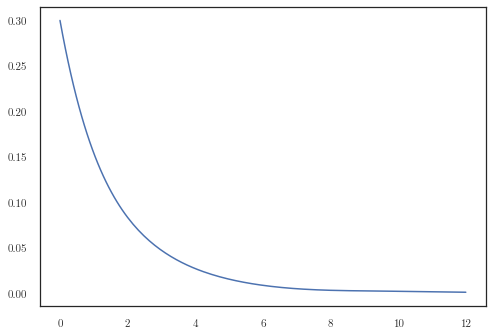

In [30]:
use_natural = False
config = VariationalConfiguration(num_samples=70)
inducing_points = torch.linspace(x_min, x_max, num_inducing).repeat(num_latents, 1).view(
    num_latents, num_inducing, 1)
t_predict = torch.linspace(0, x_max, 151, dtype=torch.float32)

periodic = True
mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
with torch.no_grad():
    mean_module.constant -= 0.2
track_parameters = ['raw_growth', 'raw_decay']

if periodic:
    covar_module = gpytorch.kernels.ScaleKernel(
        gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([num_latents])),
        batch_shape=torch.Size([num_latents])
    )  # * \
    # gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents]))

    print(covar_module.base_kernel.period_length)
    covar_module.base_kernel.lengthscale = 3
    covar_module.base_kernel.period_length = 8
    track_parameters.append('gp_model.covar_module.base_kernel.raw_lengthscale')
    track_parameters.append('gp_model.covar_module.base_kernel.raw_period_length')
    # covar_module.kernels[1].lengthscale = 2
else:
    covar_module = gpytorch.kernels.RBFKernel(
        batch_shape=torch.Size([num_latents]),
        lengthscale_constraint=Interval(1, 6))
    covar_module.lengthscale = 2
    track_parameters.append('gp_model.covar_module.raw_lengthscale')

gp_model = MultiOutputGP(mean_module, covar_module,
                         inducing_points, num_latents,
                         natural=use_natural)

    # print(covar_module.base_kernel.kernels)
    # covar_module.base_kernel.kernels[0].lengthscale = 3
    # covar_module.base_kernel.kernels[0].period_length = 8
    # covar_module.base_kernel.kernels[1].lengthscale = 2

lfm = LotkaVolterra(num_outputs, gp_model, config, num_training_points=num_training)

plotter = Plotter1d(lfm, np.array(['predator']))

out = lfm(t_predict, step_size=1e-2)
plt.plot(t_predict, out.mean.detach())

In [35]:
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
else:
    optimizers = [Adam(lfm.parameters(), lr=0.02)]

trainer = VariationalTrainer(
    lfm,
    optimizers,
    dataset,
    warm_variational=50,
    track_parameters=track_parameters
)

In [51]:
trainer.train(100, report_interval=10, step_size=5e-1)

Epoch 601/700 - Loss: -0.57 (-1.32 0.76) kernel: [[[1.2767597]]]
Epoch 611/700 - Loss: -0.42 (-1.22 0.80) kernel: [[[1.2811464]]]
Epoch 621/700 - Loss: 0.02 (-0.82 0.84) kernel: [[[1.3195823]]]
Epoch 631/700 - Loss: -0.24 (-1.04 0.80) kernel: [[[1.3999424]]]
Epoch 641/700 - Loss: -0.23 (-0.97 0.74) kernel: [[[1.4227283]]]
Epoch 651/700 - Loss: -0.35 (-1.10 0.74) kernel: [[[1.419665]]]
Epoch 661/700 - Loss: -0.40 (-1.14 0.73) kernel: [[[1.4061165]]]
Epoch 671/700 - Loss: -0.54 (-1.27 0.73) kernel: [[[1.3846213]]]
Epoch 681/700 - Loss: -0.61 (-1.35 0.73) kernel: [[[1.3643914]]]
Epoch 691/700 - Loss: -0.68 (-1.45 0.76) kernel: [[[1.3403941]]]


In [52]:
# print(covar_module.base_kernel.kernels[0].printeriod_length)
# print(covar_module.base_kernel.kernels[0].lengthscale)
# print(covar_module.outputscale)
# print(covar_module.base_kernel.period_length)
# covar_module.kernels[0].period_length += 1.

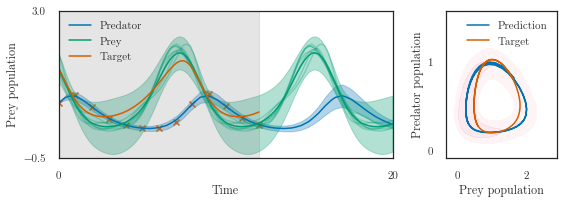

In [56]:
lfm.eval()
t_interval = (0, 20)
t_predict = torch.linspace(*t_interval, 100, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=5e-1)
q_f = lfm.predict_f(t_predict)
ylim = (-0.5, 3)
fig, axes = plt.subplots(ncols=2,
                         figsize=(8, 3),
                         gridspec_kw=dict(width_ratios=[3, 1]))
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_xlim(*t_interval)
# axes[0].legend()

plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Prey population')
axes[0].plot(dataset.times, dataset.prey, c=Colours.scatter_color, label='Target')
axes[0].set_xticks([t_predict[0], t_predict[-1]])
# axes[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=2, integer=True))
axes[0].set_yticks([ylim[0], ylim[1]])
axes[0].fill_between(t_scatter.squeeze(), ylim[0], ylim[1], alpha=0.2, color='gray')
axes[0].get_lines()[0].set_label('Predator')
axes[0].get_lines()[1].set_label('Prey')
axes[0].legend()
real_prey, real_pred = dataset.prey, dataset.predator
prey = lfm.likelihood(lfm.gp_model(t_predict))
predator = lfm(t_predict)

prey_mean = prey.mean.detach().squeeze()
predator_mean = predator.mean.detach().squeeze()
x_samples = softplus(prey.sample(torch.Size([50])).detach().squeeze())
y_samples = predator.sample(torch.Size([50])).detach().squeeze()

plot_phase(x_samples, y_samples,
           x_mean=softplus(prey_mean),
           y_mean=predator_mean,
           x_target=real_prey,
           y_target=real_pred,
           ax=axes[1])
axes[1].set_xlabel('Prey population')
axes[1].set_ylabel('Predator population')
axes[1].set_yticks([0, 1])
plt.tight_layout()
tight_kwargs = dict(bbox_inches='tight', pad_inches=0)
plt.savefig('./periodic-combined.pdf', **tight_kwargs)

None
